In [1]:
import scanpy as sc
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# compute distance of each siRNA to each negative control and compute average linkage: 
def get_avg_linkage(sirna_ids, huvec, negatives, metric):
    avg_distances = {}
    for sirna in sirna_ids: 
        current_sirna = huvec[huvec.obs["sirna"] == sirna].X
        #compute pairwise distances: 
        current_distances = pairwise_distances(negatives, current_sirna, metric=metric)
        #compute average linkage
        avg_distances[sirna] = current_distances.mean()
    return avg_distances 

# HUVEC: ML Metric

* [I. Goal](#goal)
* [II. Data exploration continued](#dataexp)
    * [A. UMAP visualizations](#umap) 
    * [B. Compute distances](#distances) 
        * [1. Euclidean](#distances1)
        * [2. Cosine](#distances2) 
    * [C. K-Means](#kmeans) 
        * [1. What are the euclidean distances of the siRNAs clustering with the negative controls?](#kmeans1)
* [III. ML metric](#ml) 
    * [A. Logistic Regression](#ml1)
        * [1. Before integration](#ml11)
        * [2. After integration](#ml12) 

## I. Goal  <a class="anchor" id="goal"></a>

*What is our goal?* <br>

-> We want to train a ML model before and after integration <br>
-> Binary classification: empty well/introduced siRNA has no effect vs. siRNA changes phenotype<br>
-> For that: need to know which siRNAs in the training/test set actually have an effect yes/no 

## II. Data exploration continued  <a class="anchor" id="dataexp"></a>

In [ ]:
# goal of the data exploration: ....

<font size="3"> **<u> A.  UMAP visualizations </u>** </font> <a class="anchor" id="umap"></a>

Read in the data: 

In [3]:
adata = sc.read_csv("/home/sarah/Downloads/Masterpraktikum/Data/embeddings.csv")
meta = pd.read_csv("/home/sarah/Downloads/Masterpraktikum/Data/metadata.csv", index_col = 0)
# change the order of the rows in the meta data to match the order in the embeddings
meta = meta.reindex(pd.read_csv("/home/sarah/Downloads/Masterpraktikum/Data/embeddings.csv", index_col = 0).index)
adata.obs = meta
adata.obs['well_row'], adata.obs['well_column'] = adata.obs['well'].str[:1], adata.obs['well'].str[1:]
huvec = adata[adata.obs["cell_type"] == "HUVEC"]
huvec.obs["sirna_well_type"] = np.where(huvec.obs.well_type ==  "treatment", "treatment", huvec.obs.sirna) 
print(huvec)

AnnData object with n_obs × n_vars = 59050 × 128
    obs: 'well_id', 'cell_type', 'dataset', 'experiment', 'plate', 'well', 'site', 'well_type', 'sirna', 'sirna_id', 'well_row', 'well_column', 'sirna_well_type'


Visualize data: 

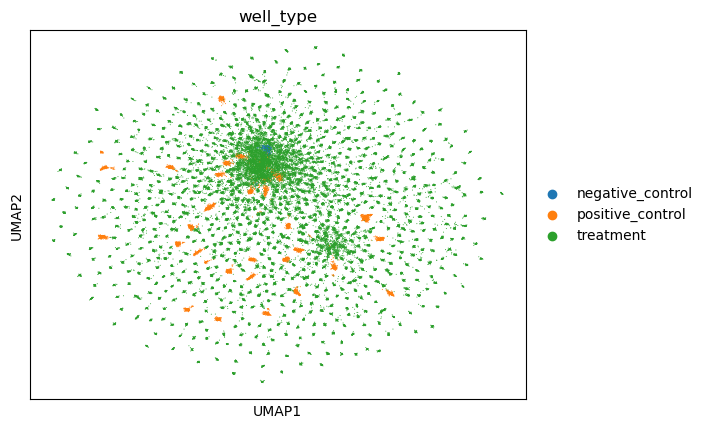

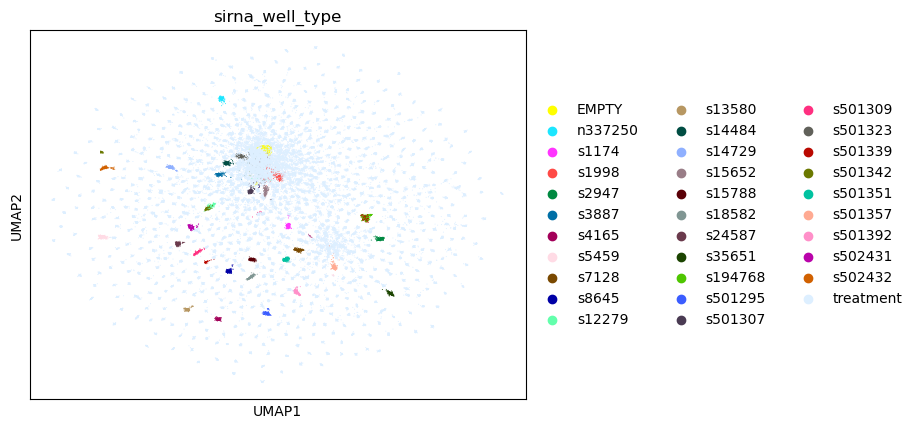

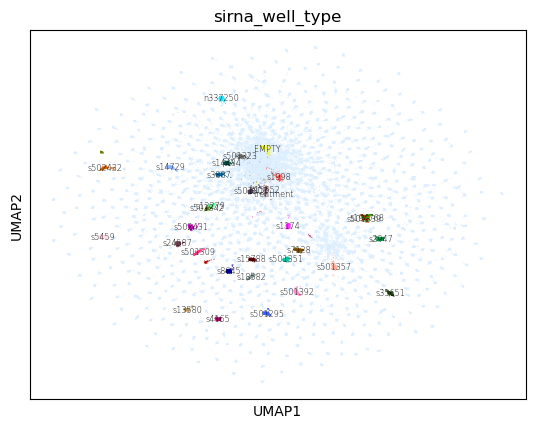

In [4]:
sc.pp.neighbors(huvec, n_neighbors=15, use_rep = "X")
sc.tl.umap(huvec)
sc.pl.umap(huvec, color="well_type")
sc.pl.umap(huvec, color="sirna_well_type") 
sc.pl.umap(huvec, color="sirna_well_type",legend_loc = "on data", legend_fontsize = "xx-small", legend_fontweight = "light")
#sc.pl.umap(huvec, color="well_type", palette={"positive_control": "grey", "treatment": "grey", "negative_control": "blue"})

The following positive control siRNAs are in the blob, near the negative controls: 

    - s1998
    - s3887
    - s14484
    - s501323
    - s501307
    - s15652

<font size="3"> **<u> B. Compute distances </u>** </font> <a class="anchor" id="distances"></a>

*Which distances do we want to compute?*

    - euclidean 
    - cosine 

*Between which points do we want to compute the distances?*

    -> we want to compute them between each siRNA and the negative controls
    -> we are computing distances between clusters -> different linkage rules
    -> In the following: average linkage 

In [23]:
#extract negative controls for later 
negatives = huvec[huvec.obs["well_type"] == "negative_control"].X

**<u> 1.  Euclidean</u>**  <a class="anchor" id="distances1"></a>

In [8]:
#only positive controls:
sirna_ids = huvec[huvec.obs["well_type"] == "positive_control"].obs['sirna'].unique()
pos_avg_distances = get_avg_linkage(sirna_ids, huvec, negatives, "euclidean")
#only treatments: 
sirna_ids = huvec[huvec.obs["well_type"] == "treatment"].obs['sirna'].unique()
treat_avg_distances = get_avg_linkage(sirna_ids, huvec, negatives, "euclidean")

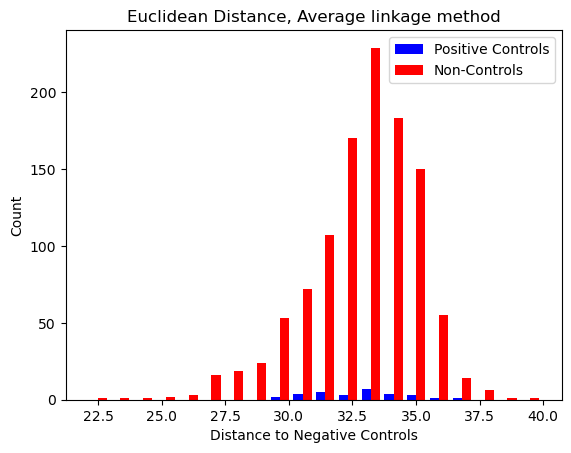

In [9]:
plt.hist([list(pos_avg_distances.values()), list(treat_avg_distances.values())]
         , color=['blue', 'red'], label=['Positive Controls', 'Non-Controls'], bins = 20)
plt.xlabel('Distance to Negative Controls')
plt.ylabel('Count')
plt.title("Euclidean Distance, Average linkage method")
plt.legend()
plt.show()

**<u> 2.  Cosine</u>** <a class="anchor" id="distances2"></a>

In [10]:
#only positive controls:
sirna_ids = huvec[huvec.obs["well_type"] == "positive_control"].obs['sirna'].unique()
pos_avg_distances = get_avg_linkage(sirna_ids, huvec, negatives, "cosine")
#only treatments: 
sirna_ids = huvec[huvec.obs["well_type"] == "treatment"].obs['sirna'].unique()
treat_avg_distances = get_avg_linkage(sirna_ids, huvec, negatives, "cosine")

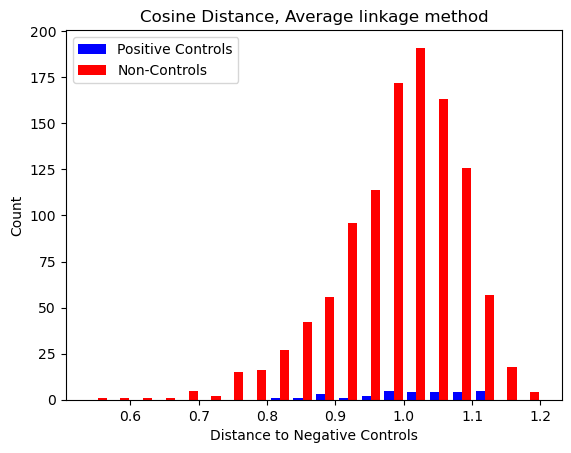

In [11]:
plt.hist([list(pos_avg_distances.values()), list(treat_avg_distances.values())]
         , color=['blue', 'red'], label=['Positive Controls', 'Non-Controls'], bins = 20)
plt.xlabel('Distance to Negative Controls')
plt.ylabel('Count')
plt.title("Cosine Distance, Average linkage method")
plt.legend()
plt.show()

<font size="3"> **<u> C.  K-Means </u>** </font> <a class="anchor" id="kmeans"></a>

-> Set k = 2 <br>
-> Which siRNAs cluster together with the negative controls? 

**Perform on whole dataset:**

In [19]:
kmeans_all = KMeans(n_clusters=2, n_init="auto").fit(huvec.X)
huvec.obs["kmeans_cluster"] = kmeans_all.labels_
huvec[huvec.obs["well_type"] == "negative_control"].obs['kmeans_cluster'].unique()

array([1], dtype=int32)

All datapoints of the negative controls are in cluster 1

Visualize results in UMAP: 

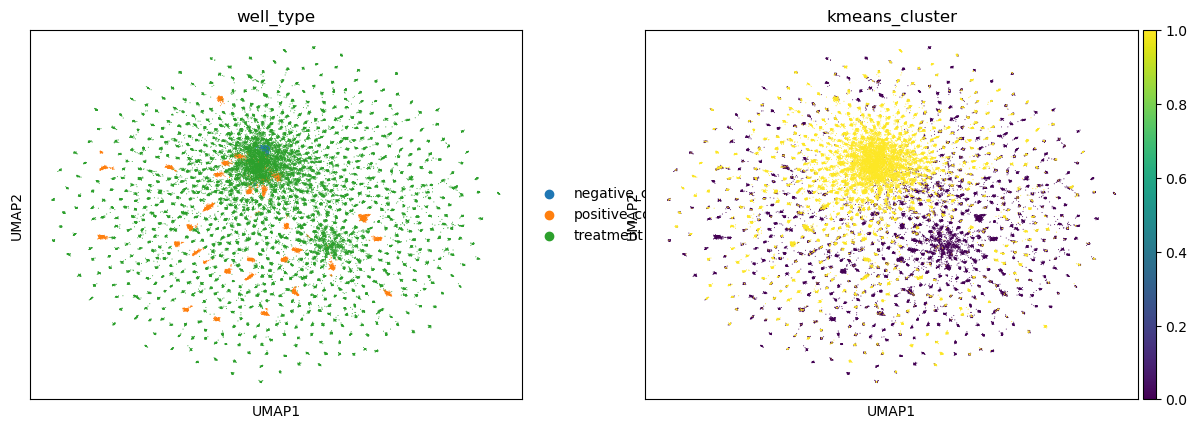

In [20]:
sc.pl.umap(huvec, color=["well_type", "kmeans_cluster"])

In [21]:
pos = huvec[(huvec.obs["well_type"] != "negative_control") & (huvec.obs["kmeans_cluster"] == 1)].obs["sirna"].unique()
print(pos)
len(pos)

['s28630', 's27572', 's224169', 's27652', 's26950', ..., 's19801', 's21658', 's28457', 's29371', 's36046']
Length: 900
Categories (900, object): ['n337250', 's134', 's256', 's317', ..., 's501351', 's501392', 's502431', 's502432']


900

900 siRNAs cluster with the negative controls 

 **<u> 1. What are the euclidean distances of the siRNAs clustering with the negative controls?</u>** <a class="anchor" id="kmeans1"></a>

Are the siRNAs clustering with the negative controls the ones with smaller e.g. euclidean distances?

In [25]:
#again get euclidean distances: 
#only positive controls:
sirna_ids = huvec[huvec.obs["well_type"] == "positive_control"].obs['sirna'].unique()
pos_avg_distances = get_avg_linkage(sirna_ids, huvec, negatives, "euclidean")
#only treatments: 
sirna_ids = huvec[huvec.obs["well_type"] == "treatment"].obs['sirna'].unique()
treat_avg_distances = get_avg_linkage(sirna_ids, huvec, negatives, "euclidean")
#extract sirna ids which are in the same class as the negative controls 
# -> == pos
#extract distances: 
sirna_clusterneg = [pos_avg_distances.get(sirna) for sirna in pos if sirna in pos_avg_distances.keys()] + [treat_avg_distances.get(sirna) for sirna in pos if sirna in treat_avg_distances.keys()]
#extract sirnas which are in a different class then the negative controls: 
neg = huvec[(huvec.obs["well_type"] != "negative_control") & (huvec.obs["kmeans_cluster"] == 0)].obs["sirna"].unique()
# extract sirnas which dont have a datapoint in the class of the neg controls & every datapoint is in cluster 0 
neg = [sirna for sirna in neg if sirna not in pos]
#get distances
sirna_clusternn = [pos_avg_distances.get(sirna) for sirna in neg if sirna in pos_avg_distances.keys()] + [treat_avg_distances.get(sirna) for sirna in neg if sirna in treat_avg_distances.keys()]

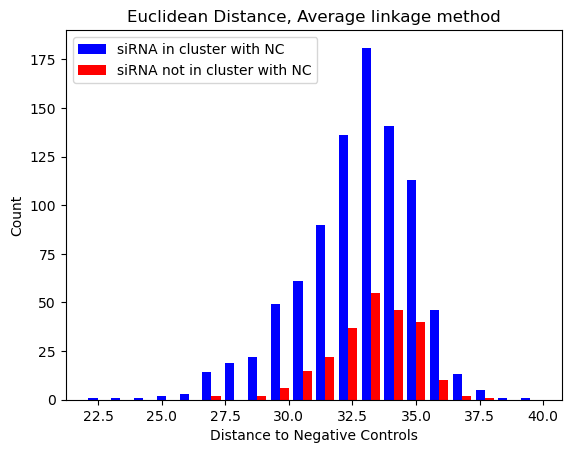

In [26]:
plt.hist([sirna_clusterneg, sirna_clusternn]
         , color=['blue', 'red'], label=['siRNA in cluster with NC', 'siRNA not in cluster with NC'], bins = 20)
plt.xlabel('Distance to Negative Controls')
plt.ylabel('Count')
plt.title("Euclidean Distance, Average linkage method")
plt.legend()
plt.show()

## III. ML metric  <a class="anchor" id="ml"></a>

<font size="3"> **<u> A.  Logistic Regression </u>** </font> <a class="anchor" id="ml1"></a>

Performance metrics: 

    - Balanced Accuracy
    - Precision 
    - Recall 

**<u> 1. Before integration</u>** <a class="anchor" id="ml11"></a>

In [6]:
# extract X and y for training: 
X = huvec[(huvec.obs["well_type"] == "negative_control") | (huvec.obs["well_type"] == "positive_control")].X
y = huvec[(huvec.obs["well_type"] == "negative_control") | (huvec.obs["well_type"] == "positive_control")].obs["well_type"]
y = np.where(y ==  "negative_control", 0, 1) 

In [21]:
# split into train/test
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):]
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.9628004179728318
0.9398496240601504


In [22]:
#fit model 
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

Performance on the training set: 

In [23]:
y_train_pred = lr.predict(X_train)
print("Confusion matrix: " + "\n"+str(confusion_matrix(y_train, y_train_pred)))
print("Balanced Accuracy: " + str(balanced_accuracy_score(y_train, y_train_pred)))
print("Recall: " + str(recall_score(y_train, y_train_pred)))
print("Precision: " + str(precision_score(y_train, y_train_pred)))

Confusion matrix: 
[[ 178    0]
 [   0 4607]]
Balanced Accuracy: 1.0
Recall: 1.0
Precision: 1.0


Performance on the test set: 

In [24]:
y_test_pred = lr.predict(X_test)
print("Confusion matrix: " + "\n"+str(confusion_matrix(y_test, y_test_pred)))
print("Balanced Accuracy: " + str(balanced_accuracy_score(y_test, y_test_pred)))
print("Recall: " + str(recall_score(y_test, y_test_pred)))
print("Precision: " + str(precision_score(y_test, y_test_pred)))

Confusion matrix: 
[[  64    8]
 [   1 1124]]
Balanced Accuracy: 0.944
Recall: 0.9991111111111111
Precision: 0.9929328621908127


Performance on the treatments: 

In [25]:
X_treatments = huvec[(huvec.obs["well_type"] == "treatment")].X
y_treatments = np.ones(len(X_treatments))

In [26]:
y_treat_pred = lr.predict(X_treatments)
print("Confusion matrix: " + "\n"+str(confusion_matrix(y_treatments, y_treat_pred)))
print("Balanced Accuracy: " + str(balanced_accuracy_score(y_treatments, y_treat_pred)))
print("Recall: " + str(recall_score(y_treatments, y_treat_pred)))
print("Precision: " + str(precision_score(y_treatments, y_treat_pred)))

Confusion matrix: 
[[    0     0]
 [  828 52240]]
Balanced Accuracy: 0.9843973769503279
Recall: 0.9843973769503279
Precision: 1.0


Get probabilities (of being of class 1) and save probs to anndata: 

In [31]:
y_train_probs = lr.predict_proba(X_train)
y_test_probs = lr.predict_proba(X_test)
y_treat_probs = lr.predict_proba(X_treatments)

In [41]:
y_pc_nc = list(y_train_probs[:,1]) + list(y_test_probs[:,1]) # extract probs of class 1

pc_nc = huvec[(huvec.obs["well_type"] == "negative_control") | (huvec.obs["well_type"] == "positive_control")]

In [43]:
pc_nc.obs["lr_probs"] = y_pc_nc
pc_nc.obs

,well_id,cell_type,dataset,experiment,plate,well,site,well_type,sirna,sirna_id,well_row,well_column,sirna_well_type,lr_probs
site_id,,,,,,,,,,,,,,
HUVEC-01_1_B02_1,HUVEC-01_1_B02,HUVEC,train,HUVEC-01,1,B02,1,negative_control,EMPTY,1138,B,02,EMPTY,0.006739
HUVEC-01_1_B02_2,HUVEC-01_1_B02,HUVEC,train,HUVEC-01,1,B02,2,negative_control,EMPTY,1138,B,02,EMPTY,0.000205
HUVEC-01_1_C03_1,HUVEC-01_1_C03,HUVEC,train,HUVEC-01,1,C03,1,positive_control,s3887,1122,C,03,s3887,0.999987
HUVEC-01_1_C03_2,HUVEC-01_1_C03,HUVEC,train,HUVEC-01,1,C03,2,positive_control,s3887,1122,C,03,s3887,1.000000
HUVEC-01_1_C07_1,HUVEC-01_1_C07,HUVEC,train,HUVEC-01,1,C07,1,positive_control,s14729,1113,C,07,s14729,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-24_4_M15_2,HUVEC-24_4_M15,HUVEC,test,HUVEC-24,4,M15,2,positive_control,s501351,1130,M,15,s501351,1.000000
HUVEC-24_4_M19_1,HUVEC-24_4_M19,HUVEC,test,HUVEC-24,4,M19,1,positive_control,s502431,1133,M,19,s502431,1.000000
HUVEC-24_4_M19_2,HUVEC-24_4_M19,HUVEC,test,HUVEC-24,4,M19,2,positive_control,s502431,1133,M,19,s502431,0.999967


In [45]:
treats = huvec[(huvec.obs["well_type"] == "treatment")]
treats.obs["lr_probs"] = y_treat_probs[:,1]
treats.obs

,well_id,cell_type,dataset,experiment,plate,well,site,well_type,sirna,sirna_id,well_row,well_column,sirna_well_type,lr_probs
site_id,,,,,,,,,,,,,,
HUVEC-01_1_B03_1,HUVEC-01_1_B03,HUVEC,train,HUVEC-01,1,B03,1,treatment,s28630,607,B,03,treatment,0.999995
HUVEC-01_1_B03_2,HUVEC-01_1_B03,HUVEC,train,HUVEC-01,1,B03,2,treatment,s28630,607,B,03,treatment,0.999996
HUVEC-01_1_B04_1,HUVEC-01_1_B04,HUVEC,train,HUVEC-01,1,B04,1,treatment,s27572,348,B,04,treatment,0.176194
HUVEC-01_1_B04_2,HUVEC-01_1_B04,HUVEC,train,HUVEC-01,1,B04,2,treatment,s27572,348,B,04,treatment,0.782987
HUVEC-01_1_B05_1,HUVEC-01_1_B05,HUVEC,train,HUVEC-01,1,B05,1,treatment,s27327,939,B,05,treatment,0.999628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC-24_4_O21_2,HUVEC-24_4_O21,HUVEC,test,HUVEC-24,4,O21,2,treatment,s225438,926,O,21,treatment,0.999998
HUVEC-24_4_O22_1,HUVEC-24_4_O22,HUVEC,test,HUVEC-24,4,O22,1,treatment,s19603,490,O,22,treatment,1.000000
HUVEC-24_4_O22_2,HUVEC-24_4_O22,HUVEC,test,HUVEC-24,4,O22,2,treatment,s19603,490,O,22,treatment,1.000000


Which treatment siRNAs have datapoints with a probability of < 0.5? 

In [48]:
treats[treats.obs["lr_probs"] < 0.5].obs["sirna"].value_counts()

sirna
s20429     42
s27949     41
s225440    39
s20888     37
s195006    36
           ..
s37207      1
s37314      1
s37855      1
s37898      1
s28666      1
Name: count, Length: 133, dtype: int64

**Reminder: HUVEC has in total 24 experiments --> 44 data points for each siRNA**

Merge obs and colour UMAP by lr_probs:

In [66]:
obs2 = pd.concat([treats.obs, pc_nc.obs])

In [63]:
huvec.obs = pd.merge(huvec.obs, obs2[["well_id", "site","lr_probs"]], on = ["well_id", "site"])

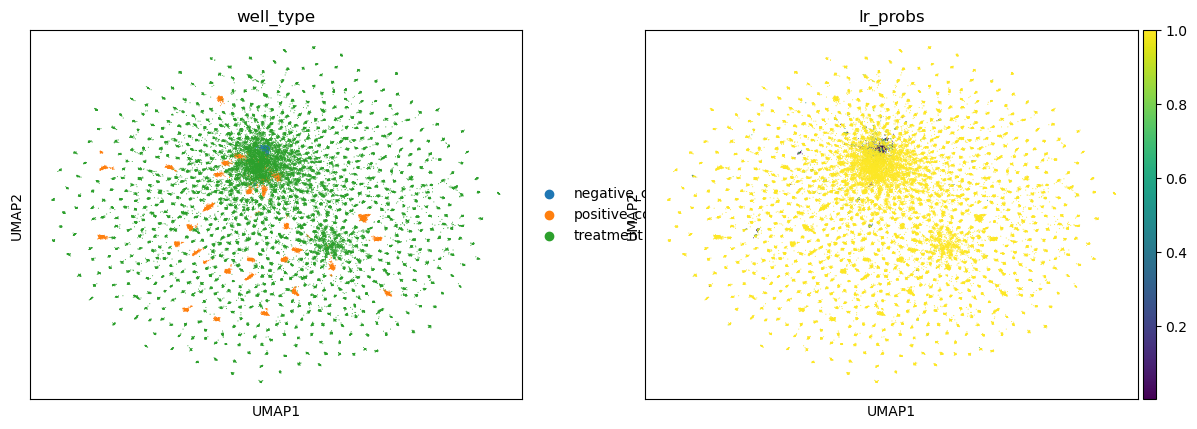

In [65]:
sc.pl.umap(huvec, color=["well_type", "lr_probs"])

Plot probabilities of treatments in histogram: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


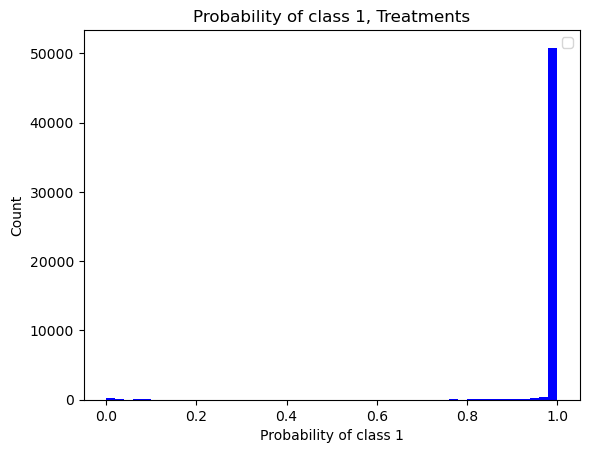

In [69]:
plt.hist(y_treat_probs[:,1]
         , color='blue', bins = 50)
plt.xlabel('Probability of class 1')
plt.ylabel('Count')
plt.title('Probability of class 1, Treatments')
plt.legend()
plt.show()

**<u> 2. After integration</u>** <a class="anchor" id="ml12"></a>

Read in Harmony-integrated dataset: 

In [3]:
huvec_harmony = sc.read_h5ad("/home/sarah/Downloads/Masterpraktikum/1.scib_metrics/RxRx1_Harmony_integrated.h5ad")
huvec_harmony

AnnData object with n_obs × n_vars = 59050 × 128
    obs: 'well_id', 'cell_type', 'dataset', 'experiment', 'plate', 'well', 'site', 'well_type', 'sirna', 'sirna_id', 'cluster'
    uns: 'experiment_colors', 'leiden', 'louvain', 'neighbors', 'pca', 'umap', 'well_type_colors'
    obsm: 'X_emb', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

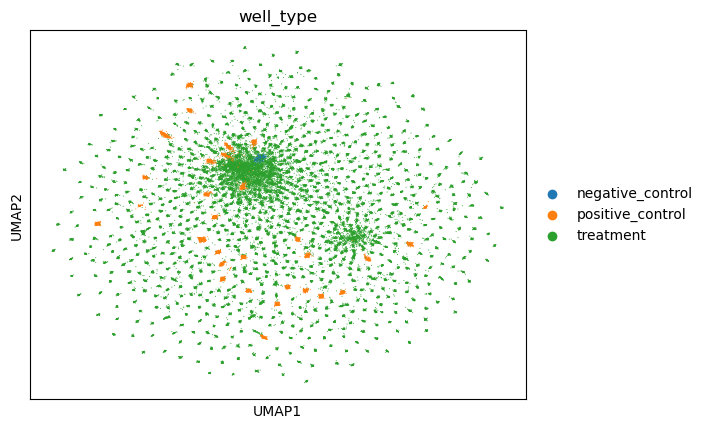

In [10]:
sc.pl.umap(huvec_harmony, color=["well_type"])

UMAP of the integrated data looks very similar to the unintegrated data

Use the same training and test split as for before integration: <br>
(but X_emb instead of X)

In [15]:
# extract X and y for training: 
X = huvec_harmony[(huvec_harmony.obs["well_type"] == "negative_control") | (huvec_harmony.obs["well_type"] == "positive_control")].obsm["X_emb"]
y = huvec_harmony[(huvec_harmony.obs["well_type"] == "negative_control") | (huvec_harmony.obs["well_type"] == "positive_control")].obs["well_type"]
y = np.where(y ==  "negative_control", 0, 1) 
# split into train/test
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):]
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.9628004179728318
0.9398496240601504


In [16]:
#fit model 
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

Performance on the training set: 

In [17]:
y_train_pred = lr.predict(X_train)
print("Confusion matrix: " + "\n"+str(confusion_matrix(y_train, y_train_pred)))
print("Balanced Accuracy: " + str(balanced_accuracy_score(y_train, y_train_pred)))
print("Recall: " + str(recall_score(y_train, y_train_pred)))
print("Precision: " + str(precision_score(y_train, y_train_pred)))

Confusion matrix: 
[[ 178    0]
 [   0 4607]]
Balanced Accuracy: 1.0
Recall: 1.0
Precision: 1.0


Performance on the test set: 

In [18]:
y_test_pred = lr.predict(X_test)
print("Confusion matrix: " + "\n"+str(confusion_matrix(y_test, y_test_pred)))
print("Balanced Accuracy: " + str(balanced_accuracy_score(y_test, y_test_pred)))
print("Recall: " + str(recall_score(y_test, y_test_pred)))
print("Precision: " + str(precision_score(y_test, y_test_pred)))

Confusion matrix: 
[[  63    9]
 [   1 1124]]
Balanced Accuracy: 0.9370555555555555
Recall: 0.9991111111111111
Precision: 0.9920564872021183


Performance on the treatments: 

In [20]:
X_treatments = huvec_harmony[(huvec_harmony.obs["well_type"] == "treatment")].obsm["X_emb"]
y_treatments = np.ones(len(X_treatments))

In [21]:
y_treat_pred = lr.predict(X_treatments)
print("Confusion matrix: " + "\n"+str(confusion_matrix(y_treatments, y_treat_pred)))
print("Balanced Accuracy: " + str(balanced_accuracy_score(y_treatments, y_treat_pred)))
print("Recall: " + str(recall_score(y_treatments, y_treat_pred)))
print("Precision: " + str(precision_score(y_treatments, y_treat_pred)))

Confusion matrix: 
[[    0     0]
 [  807 52261]]
Balanced Accuracy: 0.984793095650863
Recall: 0.984793095650863
Precision: 1.0


Get probabilities (of being of class 1) and save probs to anndata: 

In [23]:
y_train_probs = lr.predict_proba(X_train)
y_test_probs = lr.predict_proba(X_test)
y_treat_probs = lr.predict_proba(X_treatments)
y_pc_nc = list(y_train_probs[:,1]) + list(y_test_probs[:,1]) # extract probs of class 1
pc_nc = huvec_harmony[(huvec_harmony.obs["well_type"] == "negative_control") | (huvec_harmony.obs["well_type"] == "positive_control")]
pc_nc.obs["lr_probs"] = y_pc_nc
treats = huvec_harmony[(huvec_harmony.obs["well_type"] == "treatment")]
treats.obs["lr_probs"] = y_treat_probs[:,1]
obs2 = pd.concat([treats.obs, pc_nc.obs])
huvec_harmony.obs = pd.merge(huvec_harmony.obs, obs2[["well_id", "site","lr_probs"]], on = ["well_id", "site"])

Which treatment siRNAs have datapoints with a probability of < 0.5? 

In [24]:
treats[treats.obs["lr_probs"] < 0.5].obs["sirna"].value_counts()

sirna
s27949     43
s225440    40
s20566     36
s20429     36
s29230     35
           ..
s27627      1
s37586      1
s37898      1
s20290      1
s20441      1
Name: count, Length: 127, dtype: int64

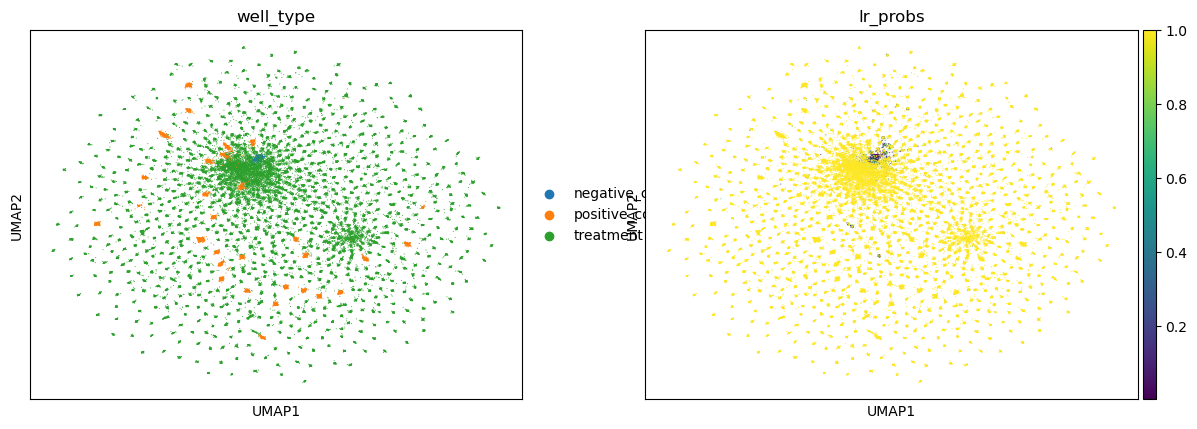

In [26]:
sc.pl.umap(huvec_harmony, color=["well_type", "lr_probs"])

Plot probabilities of treatments in histogram: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


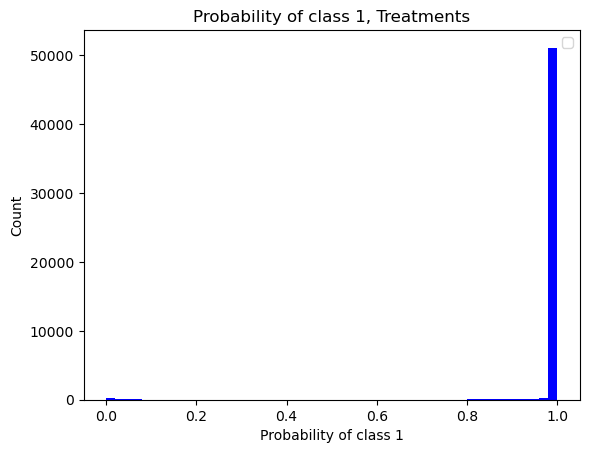

In [27]:
plt.hist(y_treat_probs[:,1]
         , color='blue', bins = 50)
plt.xlabel('Probability of class 1')
plt.ylabel('Count')
plt.title('Probability of class 1, Treatments')
plt.legend()
plt.show()